## Apply TTMs to Solar Power data

This notebooke demonstrates the usage of a pre-trained `TinyTimeMixer` model for several multivariate time series forecasting tasks. For details related to model architecture, refer to the [TTM paper](https://arxiv.org/pdf/2401.03955.pdf).

In this example, we will use a pre-trained TTM-512-96 model. That means the TTM model can take an input of 512 time points (`context_length`), and can forecast upto 96 time points (`forecast_length`) in the future. We will use the pre-trained TTM in two settings:
1. **Zero-shot**: The pre-trained TTM will be directly used to evaluate on the `test` split of the target data. Note that the TTM was NOT pre-trained on the target data.
2. **Few-shot**: The pre-trained TTM will be quickly fine-tuned on only 5% of the `train` split of the target data, and subsequently, evaluated on the `test` part of the target data.

Note: Alternatively, this notebook can be modified to try the TTM-1024-96 model.

Pre-trained TTM models will be fetched from the [Hugging Face TTM Model Repository](https://huggingface.co/ibm/TTM).

## Installation

In [2]:
# Clone the ibm/tsfm
#! git clone https://github.com/IBM/tsfm.git

In [3]:
# Change directory. Move inside the tsfm repo.
#%cd tsfm

In [4]:
# Do ls
#! ls

In [5]:
# Install the tsfm library
#! pip install ".[notebooks]"

## Imports

In [6]:
# Standard
import os
import math
import tempfile
import torch

# Third Party
from torch.optim import AdamW
from torch.optim.lr_scheduler import OneCycleLR
from transformers import EarlyStoppingCallback, Trainer, TrainingArguments, set_seed
import numpy as np
import pandas as pd

# First Party
from tsfm_public.models.tinytimemixer.utils import (
    count_parameters,
    plot_preds,
)

# Local
from tsfm_public.models.tinytimemixer import TinyTimeMixerForPrediction
from tsfm_public.toolkit.callbacks import TrackingCallback

import matplotlib.pyplot as plt

## Important arguments

In [7]:
# Set seed for reproducibility
SEED = 42
set_seed(SEED)

# DATA ROOT PATH
# Make sure to download the target data (here ettm2) on the `DATA_ROOT_PATH` folder.
# ETT is available at: https://github.com/zhouhaoyi/ETDataset/tree/main
target_dataset = "ettm2"
DATA_ROOT_PATH = "https://raw.githubusercontent.com/zhouhaoyi/ETDataset/main/ETT-small/ETTm2.csv"

# Results dir
OUT_DIR = "ttm_finetuned_models/"

# TTM model branch
# Use main for 512-96 model
# Use "1024_96_v1" for 1024-96 model
TTM_MODEL_REVISION = "main"

# Forecasting parameters
context_length = 512
forecast_length = 96

fewshot_fraction = 0.05 # we just need 5% of the data for finetuning

## Data processing pipeline

In [8]:
# Load the data file and see the columns
df_tmp = pd.read_csv(DATA_ROOT_PATH)
df_tmp

,date,HUFL,HULL,MUFL,MULL,LUFL,LULL,OT
0,2016-07-01 00:00:00,41.130001,12.481,36.535999,9.355,4.424,1.311,38.661999
1,2016-07-01 00:15:00,39.622002,11.309,35.543999,8.551,3.209,1.258,38.223000
2,2016-07-01 00:30:00,38.868000,10.555,34.365002,7.586,4.435,1.258,37.344002
3,2016-07-01 00:45:00,35.518002,9.214,32.569000,8.712,4.435,1.215,37.124001
4,2016-07-01 01:00:00,37.528000,10.136,33.936001,7.532,4.435,1.215,37.124001
...,...,...,...,...,...,...,...,...
69675,2018-06-26 18:45:00,42.722000,12.230,54.014000,12.652,-11.525,-1.418,45.986500
69676,2018-06-26 19:00:00,38.868000,10.052,49.859001,10.669,-11.525,-1.418,45.986500
69677,2018-06-26 19:15:00,39.622002,11.057,50.448002,11.795,-10.299,-1.418,45.546501
69678,2018-06-26 19:30:00,40.459999,11.392,51.841999,11.929,-11.536,-1.418,45.546501


<Axes: xlabel='date'>

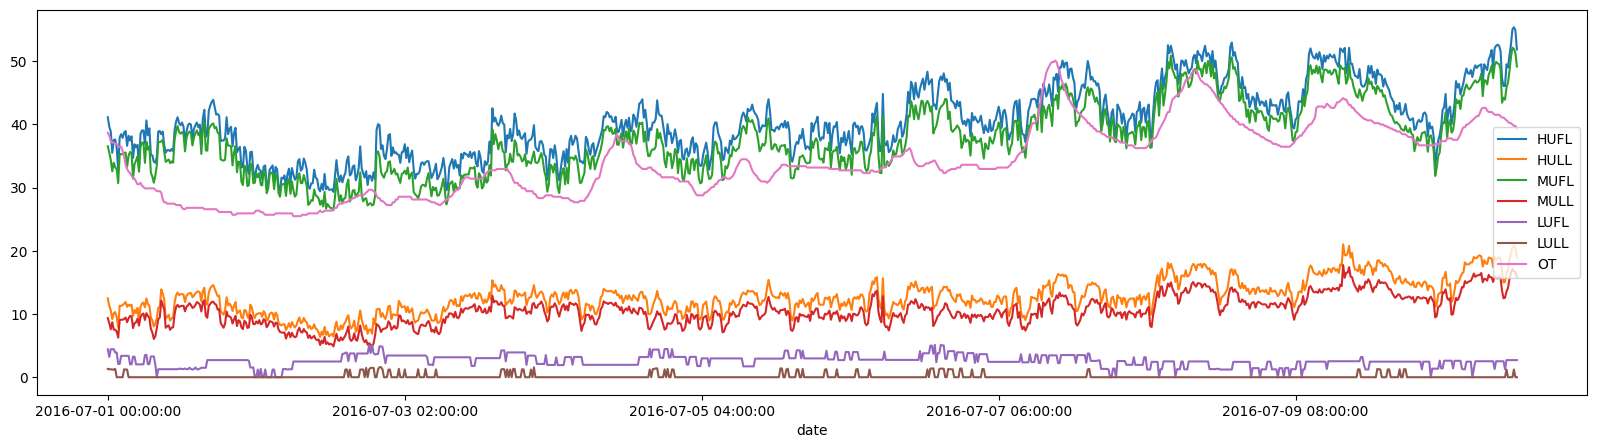

In [9]:
#df_tmp.iloc[:1000].plot(x="date", y="HUFL", figsize=(20,5))
df_tmp[0:950].plot(x='date', figsize=(20,5)) #(x="date", y="HUFL", figsize=(20,5))

### Different data
#### Solar inverter or B&V Pump data

In [14]:
df_BV = pd.read_csv('~/src/notebooks-attic/data/BVData.csv',
                       index_col=False) # parse_dates=['EVENTTIME_STRING_UTC'], 

df_BV = df_BV.drop(columns=[' ', 'Unnamed: 0', '%', 'INWC', 'DEG F', 'DEG F.1', 'NONE', 'KPPH', 'ID Fan A\\ID Fan 1Status (2=ON1=OFF)'])
df_BV['date'] = pd.to_datetime(df_BV['date'], format="%m/%d/%Y %H:%M")

In [15]:
df_BV = df_BV.set_index('date')
df_BV = df_BV.resample('1H').last().interpolate()

In [16]:
df_BV = df_BV.reset_index()
from sklearn.preprocessing import StandardScaler
stdscale = StandardScaler()
normalized_data = stdscale.fit_transform(df_BV.set_index('date'))

df_bv = pd.DataFrame(normalized_data, columns=df_BV.set_index('date').columns)
df_bv['date'] = df_BV['date']

In [21]:
df_BV['count'] = np.arange(0, 8761, 1)

In [22]:
cols2 = df_BV.columns.values.tolist()
cols2.remove('date')
cols2.remove('count')

In [24]:
#fig, ax = plt.subplots(1,1, figsize=(20,8))
#df_BV[df_BV['ID Fan A\\ID Fan 1Status (2=ON1=OFF)'] == 1].plot.scatter(x='count', c='black', lw=10, y='ID Fan A\\ID Fan 1Status (2=ON1=OFF)', ax=ax)
#df_BV.plot(x='count', y=cols2, ax=ax)

In [26]:
df_BV = df_BV.drop(columns=['count'])

<Axes: xlabel='date'>

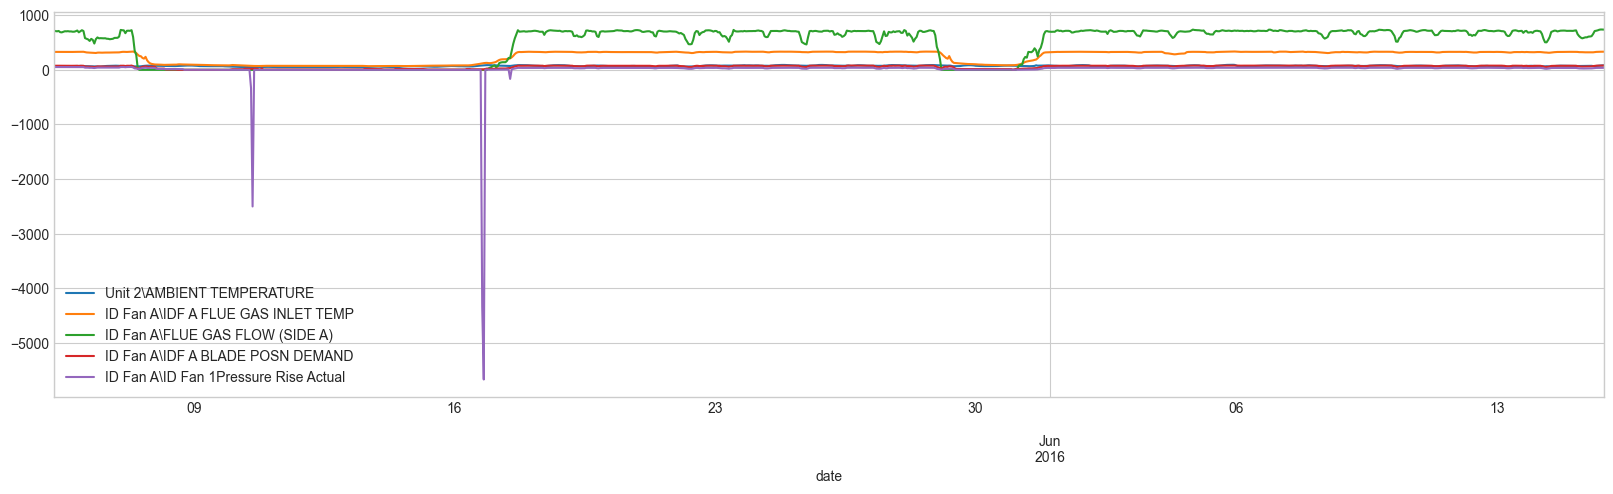

In [92]:

df_BV[3000:4000].plot(x='date', figsize=(20,5)) #(x="date", y="HUFL", figsize=(20,5))

#### Simplify - in the spirit of symbolic fourier approximation

In [28]:
from numpy.lib.stride_tricks import sliding_window_view
import scipy as sp

# apply only to regular features
cols = list(df_bv.columns)
cols.remove('date')

In [29]:
# FFT, cut off higher frequencies, IFFT
# Brute force, for the more elegant version refer to the aeon python library
length = 256
drop_coeff = 10

mult = np.array([sp.stats.norm.pdf(x) for x in range(length // 2 + 1)])

col_t = []
for col in cols:
    a_windows = sliding_window_view(df_bv[col].values, length)[::1, :]
    windows_list = []
    for i in range(a_windows.shape[0]):
        X_fft = sp.fft.rfft(a_windows[i])
        #X_fft = np.multiply(X_fft, mult)
        X_fft[drop_coeff:] = 0
        #X_fft[0] = 0
        el = sp.fft.irfft(X_fft) #[0:1]
        windows_list.append(el)
    wl = np.array(windows_list)    
    col_t.append(wl[:,0])

In [30]:
len(col_t[0])

8506

In [31]:
df_bv_sim = pd.DataFrame(data=np.array(col_t).T, columns=cols)
df_bv_sim['date'] = pd.to_datetime(df_bv['date'].values.flatten())[:len(df_bv_sim)]

<Axes: title={'center': 'Approximation'}, xlabel='date'>

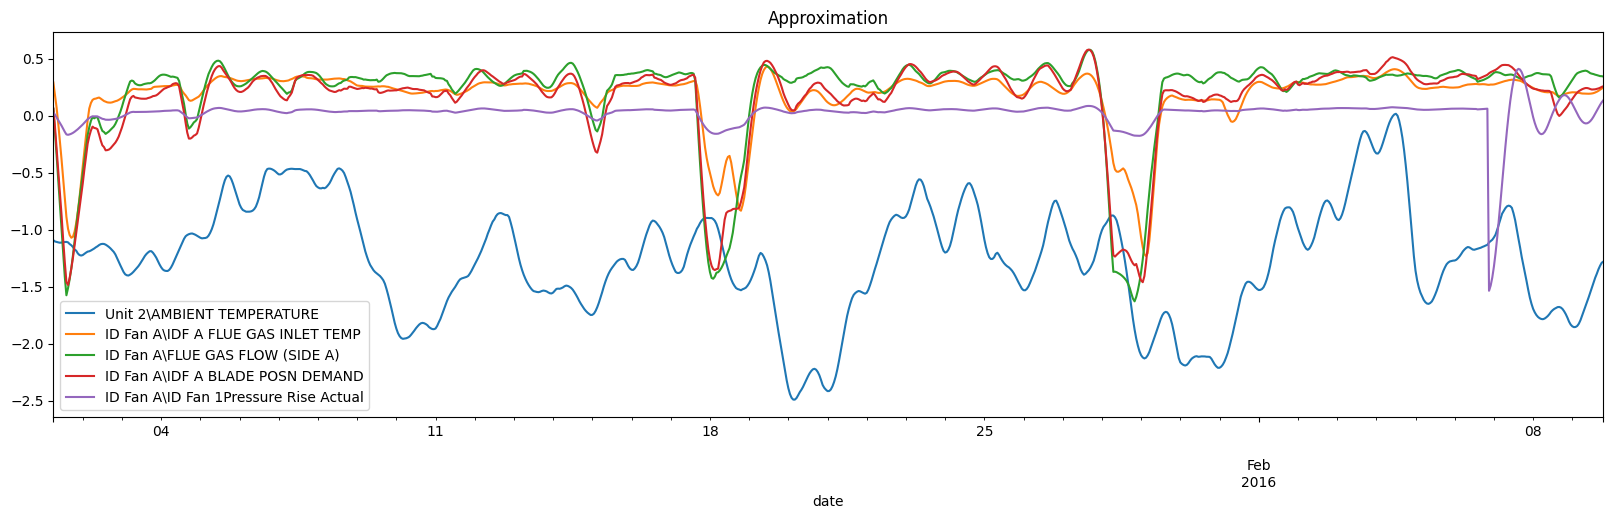

In [32]:
df_bv_sim[0:950].plot(x='date', figsize=(20,5), title='Approximation')

In [33]:
cols

['Unit 2\\AMBIENT TEMPERATURE',
 'ID Fan A\\IDF A FLUE GAS INLET TEMP',
 'ID Fan A\\FLUE GAS FLOW (SIDE A)',
 'ID Fan A\\IDF A BLADE POSN DEMAND',
 'ID Fan A\\ID Fan 1Pressure Rise Actual']

<Axes: >

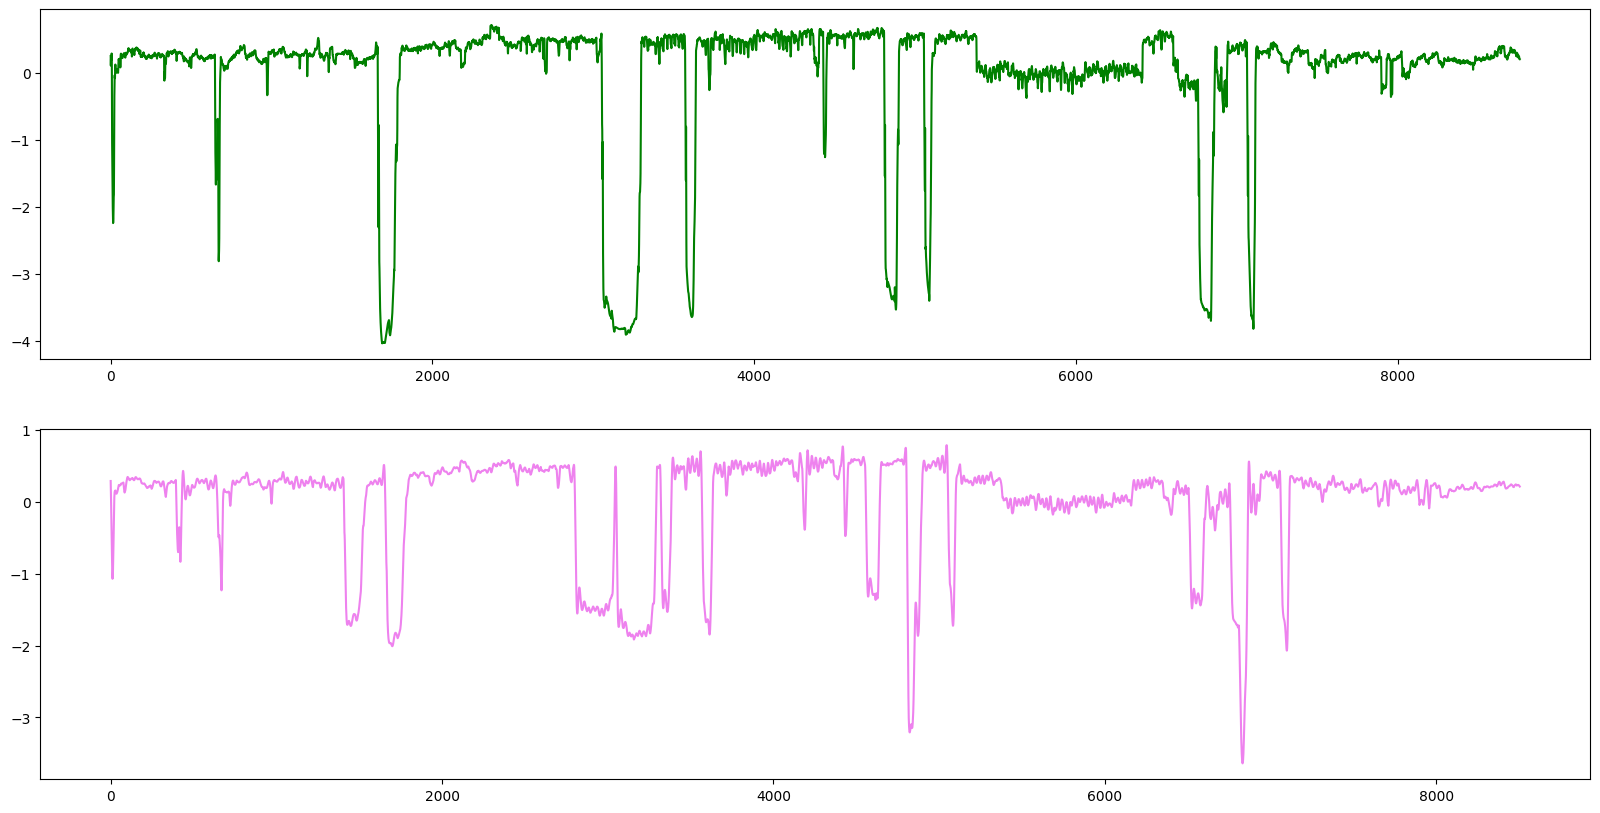

In [34]:
# Compare
colu = 'ID Fan A\\IDF A FLUE GAS INLET TEMP'
#colu = 'Voltage_volt'
#colu = 'GlobalTiltedIrradiance_wm2'
fig,ax = plt.subplots(2,1,figsize=(20,10))
df_bv[colu].plot(ax=ax[0],c='g')
df_bv_sim[colu].plot(ax=ax[1],c='violet')


#### Zero-shot forecasting - Regular time-adjusted data

In [35]:
from tsfm_public.toolkit.time_series_preprocessor import TimeSeriesPreprocessor

train_end_index = 2000

dataset_path = DATA_ROOT_PATH
timestamp_column = "date"
id_columns = []
#target_columns = ["HUFL", "HULL", "MUFL", "MULL", "LUFL", "LULL", "OT"]
target_columns = cols
split_config = {
                "train": 0.2,
                "validation" : 0.1,
                "test": 0.7
            }

data = df_bv.copy()

column_specifiers = {
    "timestamp_column": timestamp_column,
    "id_columns": id_columns,
    "target_columns": target_columns,
    "control_columns": [],
}

tsp = TimeSeriesPreprocessor(
    **column_specifiers,
    context_length=context_length,
    prediction_length=forecast_length,
    scaling=True,
    encode_categorical=False,
    freq = "0 days 01:00:00",
    scaler_type="standard",
)

fewshot_fraction = 1.0

train_dataset, valid_dataset, test_dataset = tsp.get_datasets(
    data, split_config, fewshot_fraction=fewshot_fraction, fewshot_location="first"
)
print(f"Data lengths: train = {len(train_dataset)}, val = {len(valid_dataset)}, test = {len(test_dataset)}")

Data lengths: train = 1145, val = 782, test = 6037


/tmp/ipykernel_3829076/1412236671.py:37: DeprecationWarning: Call to deprecated method get_datasets. (Please use the standalone function `get_datasets()`.) -- Deprecated since version 0.1.1.
  train_dataset, valid_dataset, test_dataset = tsp.get_datasets(


In [36]:
test_dataset.datasets[0].prediction_length

96

In [37]:
train_dataset[0]['past_values'].shape

torch.Size([512, 5])

In [38]:
#zeroshot_model = TinyTimeMixerForPrediction.from_pretrained("ibm/TTM", revision=TTM_MODEL_REVISION)
zeroshot_model = TinyTimeMixerForPrediction.from_pretrained("/home/markus/Downloads/ttm", revision=TTM_MODEL_REVISION, use_safetensors=True)
#zeroshot_model

In [39]:
temp_dir = tempfile.mkdtemp()
# zeroshot_trainer
zeroshot_trainer = Trainer(
    model=zeroshot_model,
    args=TrainingArguments(
        output_dir=temp_dir,
        per_device_eval_batch_size=64,
        skip_memory_metrics=False,
    )
)

In [40]:
zeroshot_trainer.evaluate(test_dataset)

{'eval_loss': 2.3087499141693115,
 'eval_runtime': 10.8699,
 'eval_samples_per_second': 555.387,
 'eval_steps_per_second': 8.74,
 'init_mem_cpu_alloc_delta': 1048576,
 'init_mem_cpu_peaked_delta': 0,
 'eval_mem_cpu_alloc_delta': 60162048,
 'eval_mem_cpu_peaked_delta': 0,
 'before_init_mem_cpu': 780988416}

In [74]:
j = 0
my_samples = torch.stack([test_dataset[i]['past_values'] for i in range(0, 4000, 96)])
output = zeroshot_trainer.model(my_samples)
output_fine = finetune_forecast_trainer.model(my_samples)

y_hat = output.prediction_outputs[:, :, channel].detach().cpu().numpy()
y_fine = output_fine.prediction_outputs[:, :, channel].detach().cpu().numpy()


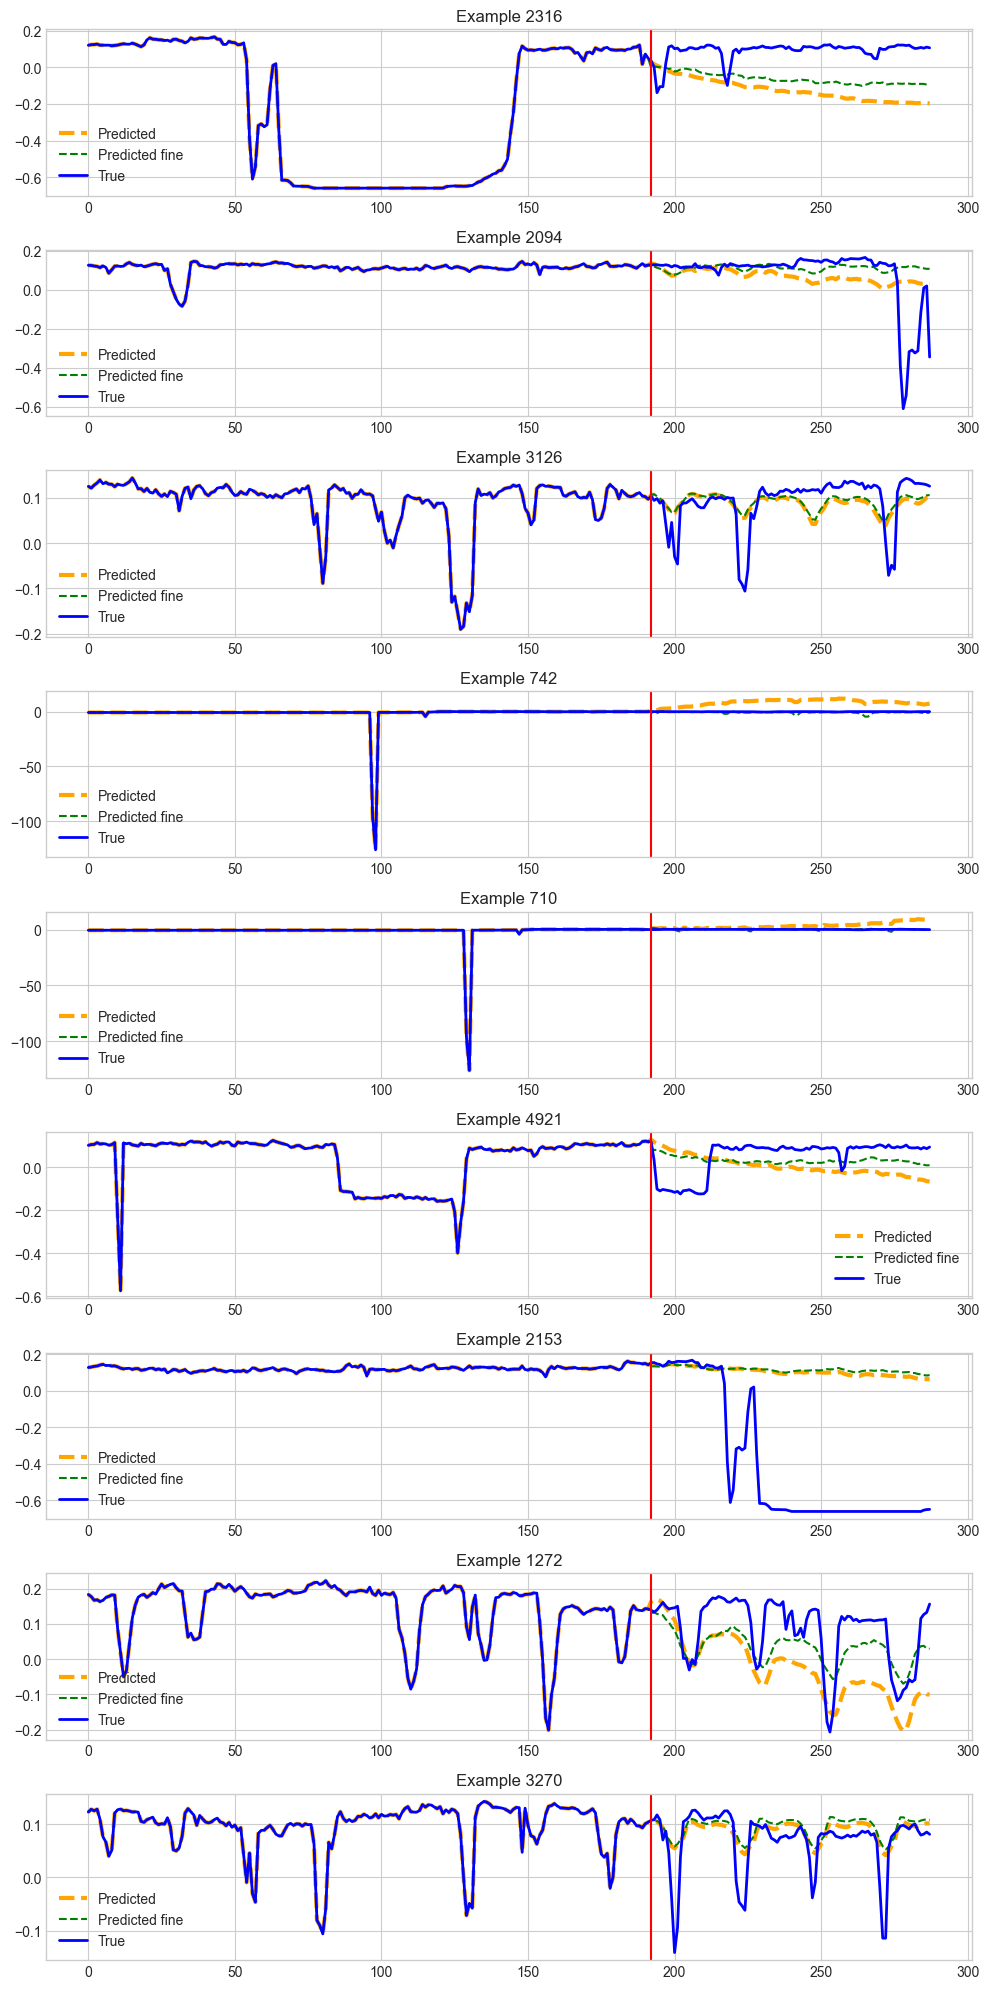

In [93]:
dset = test_dataset
channel = 4
truncate_history = True
index_list = [2316, 2094, 3126, 742, 710, 4921, 2153, 1272,3270]
my_samples = torch.stack([dset[i]["past_values"] for i in index_list])
#zeroshot_trainer.model = trainer.model.to(device)
output = zeroshot_trainer.model(my_samples)
output_fine = finetune_forecast_trainer.model(my_samples)

y_hat = output.prediction_outputs[:, :, channel].detach().cpu().numpy()
y_fine = output_fine.prediction_outputs[:, :, channel].detach().cpu().numpy()
pred_len = y_hat.shape[1]

# Set a more beautiful style
plt.style.use("seaborn-v0_8-whitegrid")

# Adjust figure size and subplot spacing
fig, axs = plt.subplots(len(index_list), 1, figsize=(10, 20))

for i, ri in enumerate(index_list):
    batch = dset[ri]

    y = batch["future_values"][:pred_len, channel].squeeze().cpu().numpy()
    if truncate_history:
        x = batch["past_values"][-2 * pred_len :, channel].squeeze().cpu().numpy()
    else:
        x = batch["past_values"][:, channel].squeeze().cpu().numpy()
    y = np.concatenate((x, y), axis=0)

    # Plot predicted values with a dashed line
    y_hat_plot = np.concatenate((x, y_hat[i, ...]), axis=0)
    axs[i].plot(y_hat_plot, label="Predicted", linestyle="--", color="orange", linewidth=3)

    # Plot predicted values with a dashed line
    y_fine_plot = np.concatenate((x, y_fine[i, ...]), axis=0)
    axs[i].plot(y_fine_plot, label="Predicted fine", linestyle="--", color="green", linewidth=1.5)

    # Plot true values with a solid line
    axs[i].plot(y, label="True", linestyle="-", color="blue", linewidth=2)

    # Plot horizon border
    axs[i].axvline(x=2 * pred_len, color="r", linestyle="-")

    axs[i].set_title(f"Example {index_list[i]}")
    axs[i].legend()

# Adjust overall layout
plt.tight_layout()


In [58]:
# plot
#plot_preds(trainer=zeroshot_trainer, dset=test_dataset, plot_dir=os.path.join(OUT_DIR, "ettm2"), plot_prefix="test_zeroshot", channel=0)

 #### Few-shot finetune and evaluation method

In [52]:
finetune_forecast_model = TinyTimeMixerForPrediction.from_pretrained("ibm/TTM", revision=TTM_MODEL_REVISION, head_dropout=0.7)
#finetune_forecast_model

#### Freeze the TTM backbone

In [53]:
print(
        "Number of params before freezing backbone",
        count_parameters(finetune_forecast_model),
    )

# Freeze the backbone of the model
for param in finetune_forecast_model.backbone.parameters():
    param.requires_grad = False

# Count params
print(
    "Number of params after freezing the backbone",
    count_parameters(finetune_forecast_model),
)

Number of params before freezing backbone 805280
Number of params after freezing the backbone 289696


#### Finetune few-shot 20%

In [54]:
# Important parameters
learning_rate = 0.001
num_epochs = 20 # Ideally, we need more epochs (try offline preferably in a gpu for faster computation)
batch_size = 64

In [55]:
print(f"Using learning rate = {learning_rate}")
finetune_forecast_args = TrainingArguments(
    output_dir=os.path.join(OUT_DIR, "output"),
    overwrite_output_dir=True,
    learning_rate=learning_rate,
    num_train_epochs=num_epochs,
    do_eval=True,
    evaluation_strategy="epoch",
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    dataloader_num_workers=8,
    report_to=None,
    save_strategy="epoch",
    logging_strategy="epoch",
    save_total_limit=1,
    logging_dir=os.path.join(OUT_DIR, "logs"),  # Make sure to specify a logging directory
    load_best_model_at_end=True,  # Load the best model when training ends
    metric_for_best_model="eval_loss",  # Metric to monitor for early stopping
    greater_is_better=False,  # For loss
    skip_memory_metrics=False,
)

# Create the early stopping callback
early_stopping_callback = EarlyStoppingCallback(
    early_stopping_patience=10,  # Number of epochs with no improvement after which to stop
    early_stopping_threshold=0.0,  # Minimum improvement required to consider as improvement
)
tracking_callback = TrackingCallback()

# Optimizer and scheduler
optimizer = AdamW(finetune_forecast_model.parameters(), lr=learning_rate)
scheduler = OneCycleLR(
    optimizer,
    learning_rate,
    epochs=num_epochs,
    steps_per_epoch=math.ceil(len(train_dataset) / (batch_size)),
)

finetune_forecast_trainer = Trainer(
    model=finetune_forecast_model,
    args=finetune_forecast_args,
    train_dataset=train_dataset,
    eval_dataset=valid_dataset,
    callbacks=[early_stopping_callback, tracking_callback],
    optimizers=(optimizer, scheduler),
)

# Fine tune
finetune_forecast_trainer.train()

Using learning rate = 0.001


/home/markus/.local/lib/python3.12/site-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss
1,5.656200,0.463431
2,4.672500,0.447627
3,3.980300,0.407136
4,2.156200,0.337472
5,1.156300,0.381203
6,1.074400,0.392247
7,1.029200,0.379807
8,0.993000,0.391666
9,0.977600,0.392667
10,0.970100,0.382766


[TrackingCallback] Mean Epoch Time = 6.9558501073292325 seconds, Total Train Time = 139.8651328086853


TrainOutput(global_step=252, training_loss=1.8919874902755496, metrics={'train_runtime': 139.4297, 'train_samples_per_second': 164.24, 'train_steps_per_second': 2.582, 'total_flos': 198276685824000.0, 'train_loss': 1.8919874902755496, 'init_mem_cpu_alloc_delta': 131072, 'init_mem_cpu_peaked_delta': 0, 'train_mem_cpu_alloc_delta': 44486656, 'train_mem_cpu_peaked_delta': 3170304, 'before_init_mem_cpu': 938303488, 'epoch': 14.0})

In [56]:
finetune_forecast_trainer.evaluate(test_dataset)

{'eval_loss': 1.8663944005966187,
 'eval_runtime': 11.6691,
 'eval_samples_per_second': 517.347,
 'eval_steps_per_second': 8.141,
 'epoch': 14.0,
 'eval_mem_cpu_alloc_delta': 0,
 'eval_mem_cpu_peaked_delta': 770048}

In [62]:
#plot_preds(trainer=finetune_forecast_trainer, dset=test_dataset, 
#           plot_dir=os.path.join(OUT_DIR, "ettm2"), plot_prefix="test_zeroshot", channel=0)

### Zero-shot simplified data

In [94]:
train_end_index = 2000

dataset_path = DATA_ROOT_PATH
timestamp_column = "date"
id_columns = []
#target_columns = ["HUFL", "HULL", "MUFL", "MULL", "LUFL", "LULL", "OT"]
target_columns = cols
split_config = {
                "train": 0.2,
                "validation" : 0.1,
                "test": 0.7
            }

data = df_bv_sim.copy()

column_specifiers = {
    "timestamp_column": timestamp_column,
    "id_columns": id_columns,
    "target_columns": target_columns,
    "control_columns": [],
}

tsp = TimeSeriesPreprocessor(
    **column_specifiers,
    context_length=context_length,
    prediction_length=forecast_length,
    scaling=True,
    encode_categorical=False,
    freq = "0 days 01:00:00",
    scaler_type="standard",
)

fewshot_fraction = 1.0

train_dataset, valid_dataset, test_dataset = tsp.get_datasets(
    data, split_config, fewshot_fraction=fewshot_fraction, fewshot_location="first"
)
print(f"Data lengths: train = {len(train_dataset)}, val = {len(valid_dataset)}, test = {len(test_dataset)}")

/tmp/ipykernel_3829076/127451857.py:35: DeprecationWarning: Call to deprecated method get_datasets. (Please use the standalone function `get_datasets()`.) -- Deprecated since version 0.1.1.
  train_dataset, valid_dataset, test_dataset = tsp.get_datasets(


Data lengths: train = 1094, val = 756, test = 5859


In [95]:
temp_dir = tempfile.mkdtemp()
# zeroshot_trainer
zeroshot_trainer_sim = Trainer(
    model=zeroshot_model,
    args=TrainingArguments(
        output_dir=temp_dir,
        per_device_eval_batch_size=64,
        skip_memory_metrics=False,
    )
)

In [96]:
zeroshot_trainer_sim.evaluate(test_dataset)

{'eval_loss': 3.5028297901153564,
 'eval_runtime': 41.1465,
 'eval_samples_per_second': 142.393,
 'eval_steps_per_second': 2.236,
 'init_mem_cpu_alloc_delta': 1703936,
 'init_mem_cpu_peaked_delta': 0,
 'eval_mem_cpu_alloc_delta': 20316160,
 'eval_mem_cpu_peaked_delta': 0,
 'before_init_mem_cpu': 924135424}

In [97]:
finetune_forecast_model_sim = TinyTimeMixerForPrediction.from_pretrained("ibm/TTM", revision=TTM_MODEL_REVISION, head_dropout=0.7)

# Freeze the backbone of the model
#for param in finetune_forecast_model.backbone.parameters():
#    param.requires_grad = False

# Important parameters
learning_rate = 0.001
num_epochs = 10 # Ideally, we need more epochs (try offline preferably in a gpu for faster computation)
batch_size = 64

In [98]:
finetune_forecast_args = TrainingArguments(
    output_dir=os.path.join(OUT_DIR, "output"),
    overwrite_output_dir=True,
    learning_rate=learning_rate,
    num_train_epochs=num_epochs,
    do_eval=True,
    evaluation_strategy="epoch",
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    dataloader_num_workers=8,
    report_to=None,
    save_strategy="epoch",
    logging_strategy="epoch",
    save_total_limit=1,
    logging_dir=os.path.join(OUT_DIR, "logs"),  # Make sure to specify a logging directory
    load_best_model_at_end=True,  # Load the best model when training ends
    metric_for_best_model="eval_loss",  # Metric to monitor for early stopping
    greater_is_better=False,  # For loss
    skip_memory_metrics=False,
)

# Create the early stopping callback
early_stopping_callback = EarlyStoppingCallback(
    early_stopping_patience=10,  # Number of epochs with no improvement after which to stop
    early_stopping_threshold=0.0,  # Minimum improvement required to consider as improvement
)
tracking_callback = TrackingCallback()

# Optimizer and scheduler
optimizer = AdamW(finetune_forecast_model_sim.parameters(), lr=learning_rate)
scheduler = OneCycleLR(
    optimizer,
    learning_rate,
    epochs=num_epochs,
    steps_per_epoch=math.ceil(len(train_dataset) / (batch_size)),
)

finetune_forecast_trainer_sim = Trainer(
    model=finetune_forecast_model_sim,
    args=finetune_forecast_args,
    train_dataset=train_dataset,
    eval_dataset=valid_dataset,
    callbacks=[early_stopping_callback, tracking_callback],
    optimizers=(optimizer, scheduler),
)

# Fine tune
finetune_forecast_trainer_sim.train()

/home/markus/.local/lib/python3.12/site-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss
1,2.003200,0.621871
2,1.473100,0.779735
3,1.036900,0.650011
4,0.847000,0.696602
5,0.770800,0.727523
6,0.719800,0.702776
7,0.695100,0.715863
8,0.663200,0.699818
9,0.654400,0.706796
10,0.652700,0.709100


[TrackingCallback] Mean Epoch Time = 22.377524495124817 seconds, Total Train Time = 285.2439835071564


TrainOutput(global_step=180, training_loss=0.9516279061635335, metrics={'train_runtime': 283.9962, 'train_samples_per_second': 38.522, 'train_steps_per_second': 0.634, 'total_flos': 135317962752000.0, 'train_loss': 0.9516279061635335, 'init_mem_cpu_alloc_delta': 0, 'init_mem_cpu_peaked_delta': 0, 'train_mem_cpu_alloc_delta': 244662272, 'train_mem_cpu_peaked_delta': 25673728, 'before_init_mem_cpu': 949792768, 'epoch': 10.0})

In [99]:
finetune_forecast_trainer_sim.evaluate(test_dataset)

{'eval_loss': 3.0400543212890625,
 'eval_runtime': 36.8976,
 'eval_samples_per_second': 158.791,
 'eval_steps_per_second': 2.493,
 'epoch': 10.0,
 'eval_mem_cpu_alloc_delta': -8388608,
 'eval_mem_cpu_peaked_delta': 12324864}

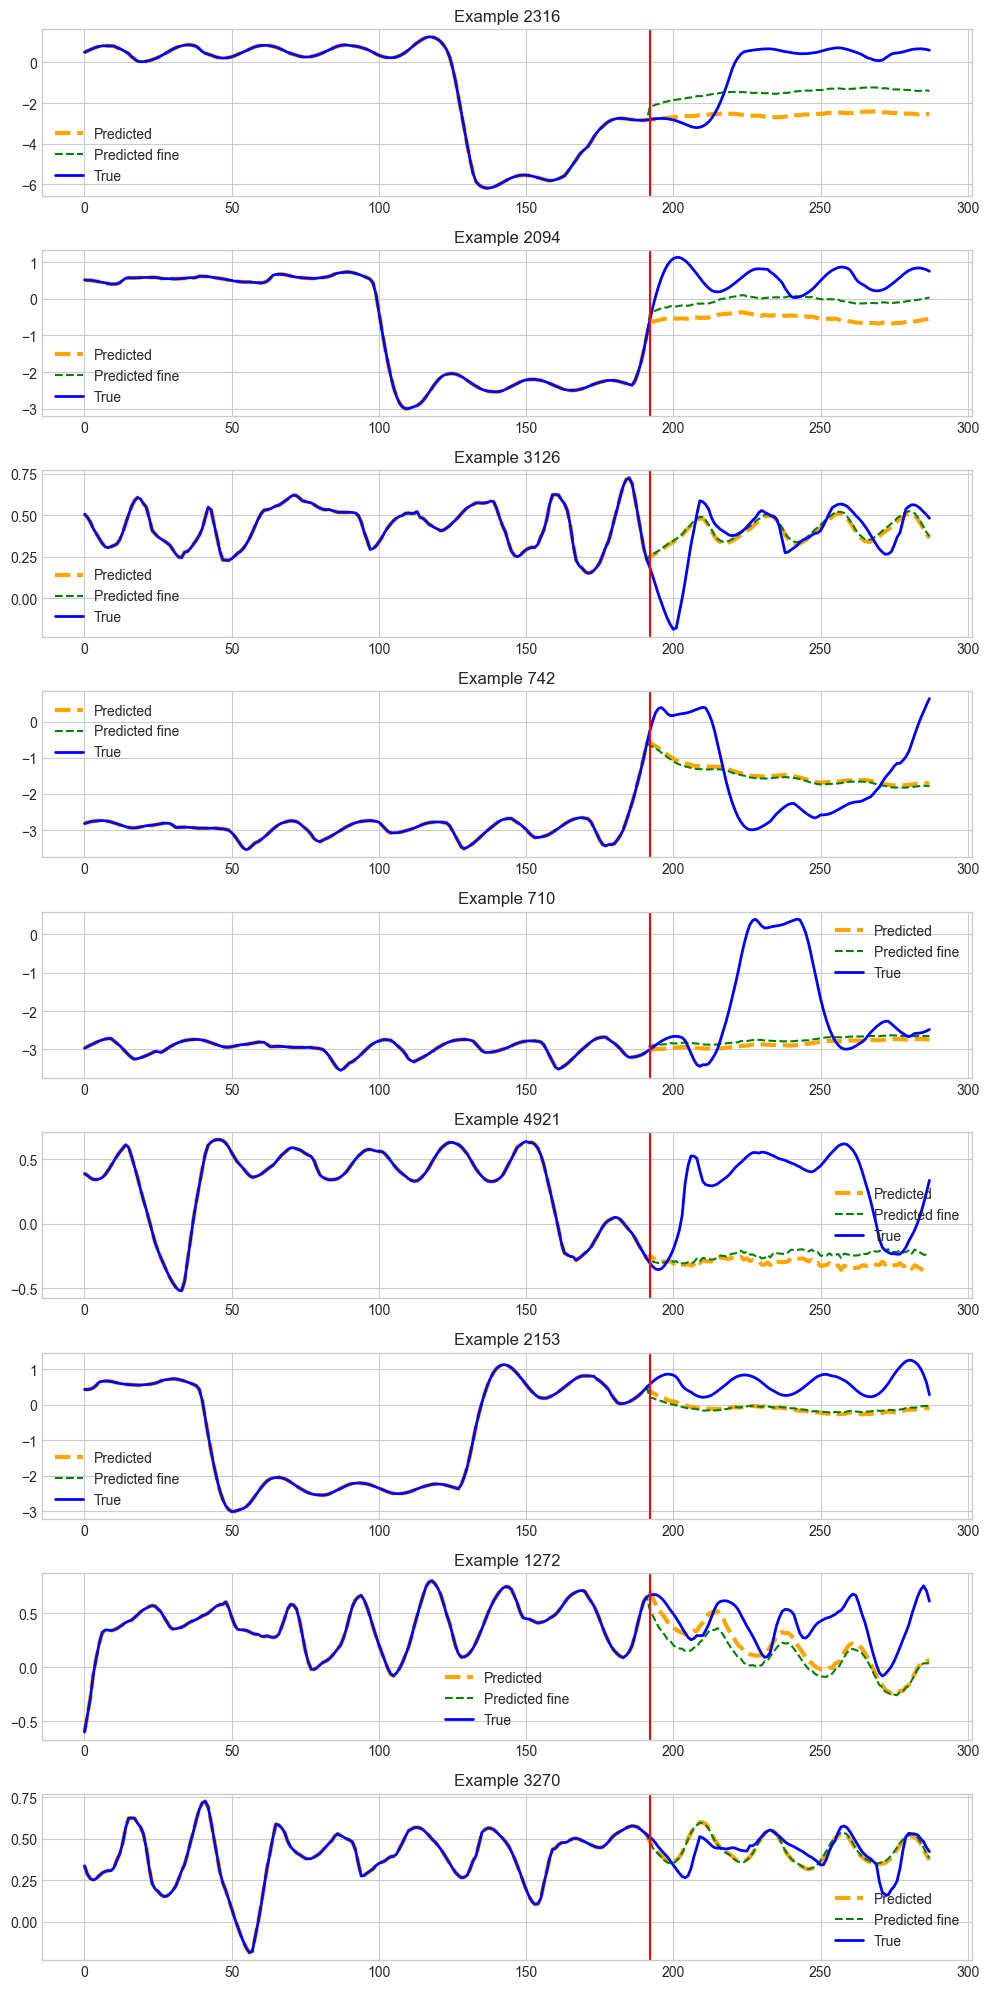

In [101]:
dset = test_dataset
channel = 2
truncate_history = True
index_list = [2316, 2094, 3126, 742, 710, 4921, 2153, 1272,3270]
my_samples = torch.stack([dset[i]["past_values"] for i in index_list])
#zeroshot_trainer.model = trainer.model.to(device)
output = zeroshot_trainer_sim.model(my_samples)
output_fine = finetune_forecast_trainer_sim.model(my_samples)

y_hat = output.prediction_outputs[:, :, channel].detach().cpu().numpy()
y_fine = output_fine.prediction_outputs[:, :, channel].detach().cpu().numpy()
pred_len = y_hat.shape[1]

# Set a more beautiful style
plt.style.use("seaborn-v0_8-whitegrid")

# Adjust figure size and subplot spacing
fig, axs = plt.subplots(len(index_list), 1, figsize=(10, 20))

for i, ri in enumerate(index_list):
    batch = dset[ri]

    y = batch["future_values"][:pred_len, channel].squeeze().cpu().numpy()
    if truncate_history:
        x = batch["past_values"][-2 * pred_len :, channel].squeeze().cpu().numpy()
    else:
        x = batch["past_values"][:, channel].squeeze().cpu().numpy()
    y = np.concatenate((x, y), axis=0)

    # Plot predicted values with a dashed line
    y_hat_plot = np.concatenate((x, y_hat[i, ...]), axis=0)
    axs[i].plot(y_hat_plot, label="Predicted", linestyle="--", color="orange", linewidth=3)

    # Plot predicted values with a dashed line
    y_fine_plot = np.concatenate((x, y_fine[i, ...]), axis=0)
    axs[i].plot(y_fine_plot, label="Predicted fine", linestyle="--", color="green", linewidth=1.5)

    # Plot true values with a solid line
    axs[i].plot(y, label="True", linestyle="-", color="blue", linewidth=2)

    # Plot horizon border
    axs[i].axvline(x=2 * pred_len, color="r", linestyle="-")

    axs[i].set_title(f"Example {index_list[i]}")
    axs[i].legend()

# Adjust overall layout
plt.tight_layout()

In [618]:
import logging
logging.basicConfig(level=50)
# workaround via specifying an invalid value first
%config Application.log_level='WORKAROUND'
# => fails, necessary on Fedora 27, ipython3 6.2.1
%config Application.log_level='DEBUG'
import logging
logging.getLogger().setLevel(logging.DEBUG)
log = logging.getLogger()
log.debug('Test debug')

[IPKernelApp] 
*** MESSAGE TYPE:execute_request***
[IPKernelApp]    Content: {'silent': False, 'store_history': True, 'user_expressions': {}, 'allow_stdin': True, 'stop_on_error': True, 'code': "import logging\nlogging.basicConfig(level=50)\n# workaround via specifying an invalid value first\n%config Application.log_level='WORKAROUND'\n# => fails, necessary on Fedora 27, ipython3 6.2.1\n%config Application.log_level='DEBUG'\nimport logging\nlogging.getLogger().setLevel(logging.DEBUG)\nlog = logging.getLogger()\nlog.debug('Test debug')"}
   --->
   
[IPKernelApp] execute_request: {'header': {'date': datetime.datetime(2024, 8, 1, 11, 52, 13, 169000, tzinfo=tzutc()), 'msg_id': 'fefe888f-d744-4e81-99f6-e489eb63c0a9', 'msg_type': 'execute_request', 'session': '3886830f-faf0-4391-aeba-c353b6da1a8b', 'username': '', 'version': '5.2'}, 'msg_id': 'fefe888f-d744-4e81-99f6-e489eb63c0a9', 'msg_type': 'execute_request', 'parent_header': {}, 'metadata': {'trusted': True, 'deletedCells': [], 'recordT

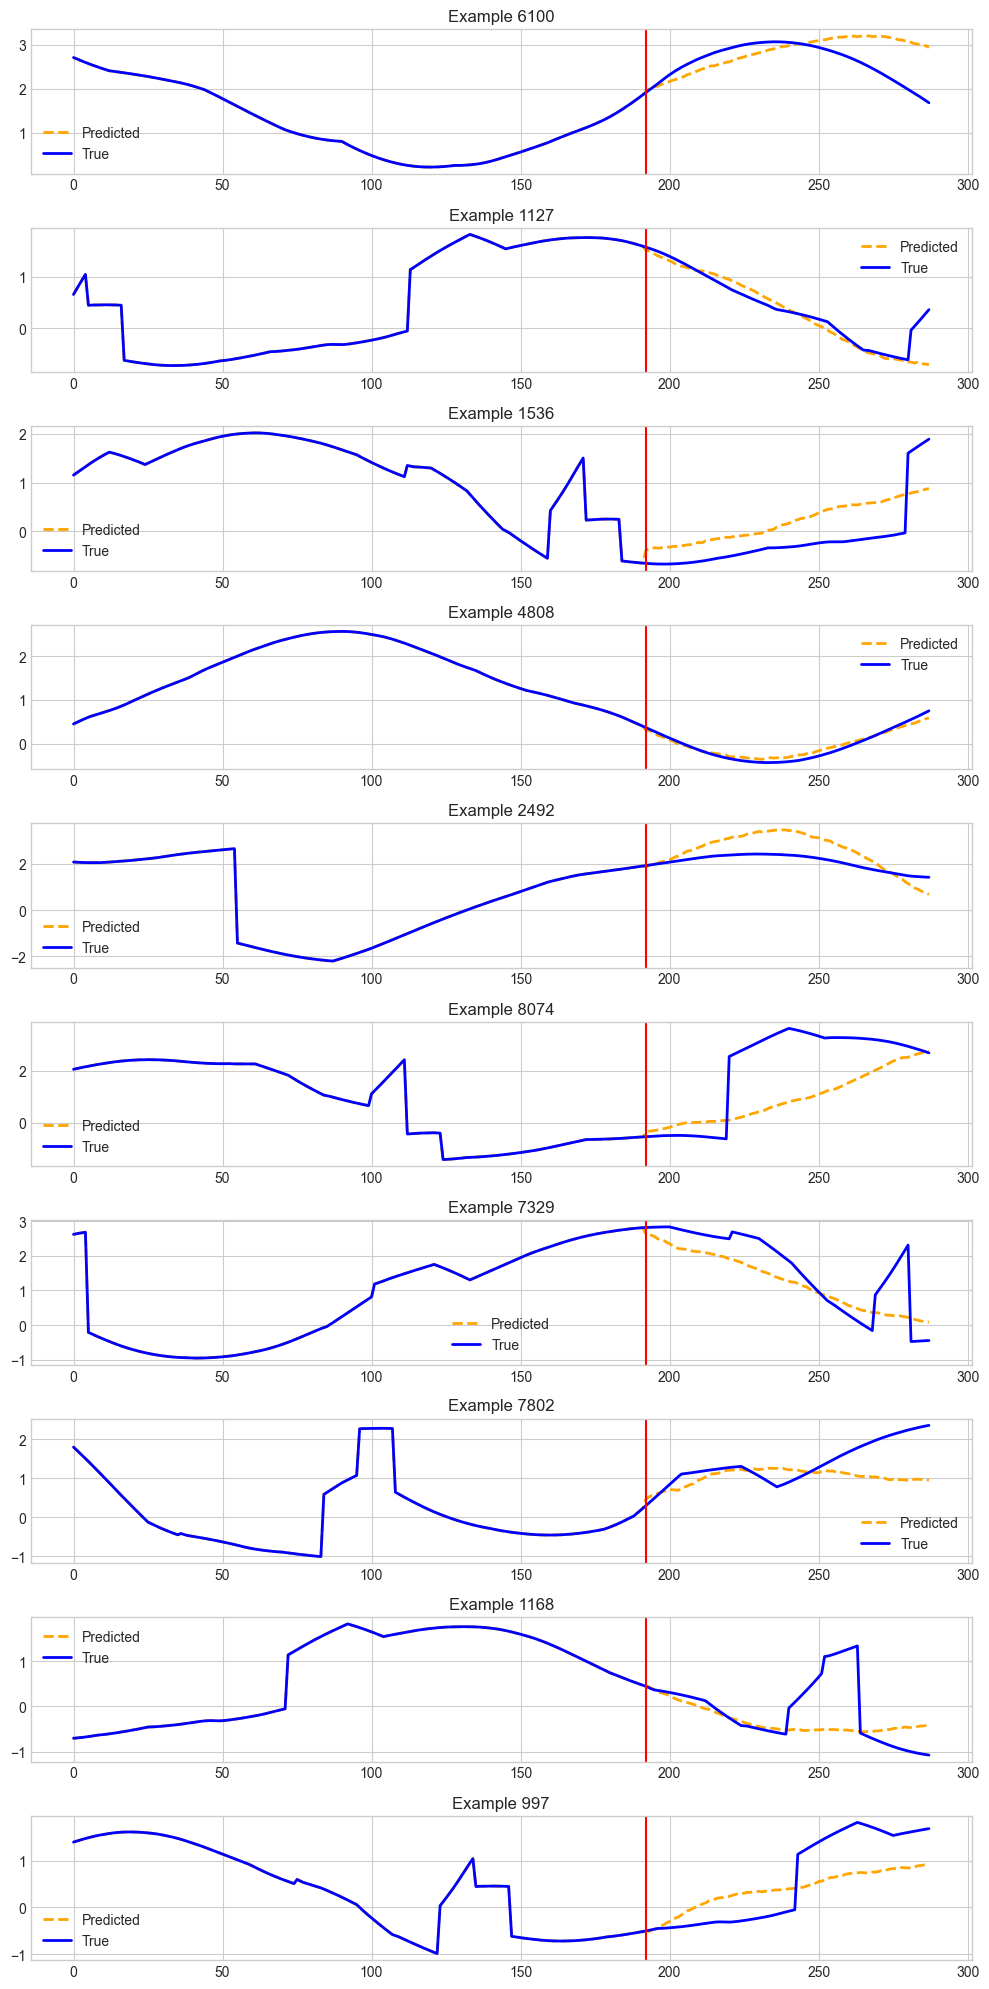

In [493]:
plot_preds(trainer=finetune_forecast_trainer, dset=test_dataset, plot_dir=os.path.join(OUT_DIR, "ettm2"), plot_prefix="test_fewshot", channel=0)

## Hands-on Questions

### Q 15.	Zero-shot on etth1. 
In your notebook, modify the zero-shot code to try it on etth1 dataset. Etth1 is available on https://raw.githubusercontent.com/zhouhaoyi/ETDataset/main/ETT-small/ETTh1.csv. 
Use the following train/val/test splits:
```
split_config = {
                "train": [0, 12 * 30 * 24],
                "valid": [12 * 30 * 24, 12 * 30 * 24 + 4 * 30 * 24],
                "test": [
                    12 * 30 * 24 + 4 * 30 * 24,
                    12 * 30 * 24 + 8 * 30 * 24,
                ],
            }
```

### Q 16.	Zero-shot on etth1 by truncating the length
Let’s say your application needs to forecast 24 hours in the future. You can still use the 512-96 TTM model and set `prediction_filter_length=24` argument during model loading. Try it on etth1, and note the evaluation error (on all channels)?

### Q 17.	Few-shot on etth1
Try few-shot 5% forecasting on etth1. Freeze the backbone and fine-tune for only 1 epoch. What is the evaluation error you get?

### Q 18.	Few-shot on etth1 by changing loss function
Try few-shot 5% forecasting on etth1 by changing the `loss` to `mae` (mean absolute error). Freeze the backbone and fine-tune for only 1 epoch. What is the evaluation error you get?

### Q 19.	Zero-shot on channel 0 and 2 for etth1
In your notebook, add `prediction_channel_indices=[0,2]` during model loading to forecast only 0th and 2nd channels. In this case, execute the following code and note the output shape.
```
zeroshot_model = TinyTimeMixerForPrediction.from_pretrained("ibm/TTM", revision=TTM_MODEL_REVISION, prediction_channel_indices=[0,2])
output = zeroshot_model.forward(test_dataset[0]['past_values'].unsqueeze(0), return_loss=False)
output.prediction_outputs.shape
```

In [102]:
from IPython.display import display, HTML
display(HTML("<style>:root { --jp-notebook-max-width: 80% !important; }</style>"))

In [63]:
gv = str(model_graph.visual_graph)
gv = gv.replace('16.8,16.8', '20,20')
graph = graphviz.Source(gv)

In [25]:
import graphviz
graphviz.set_jupyter_format('svg')
#model_graph.visual_graph

'svg'

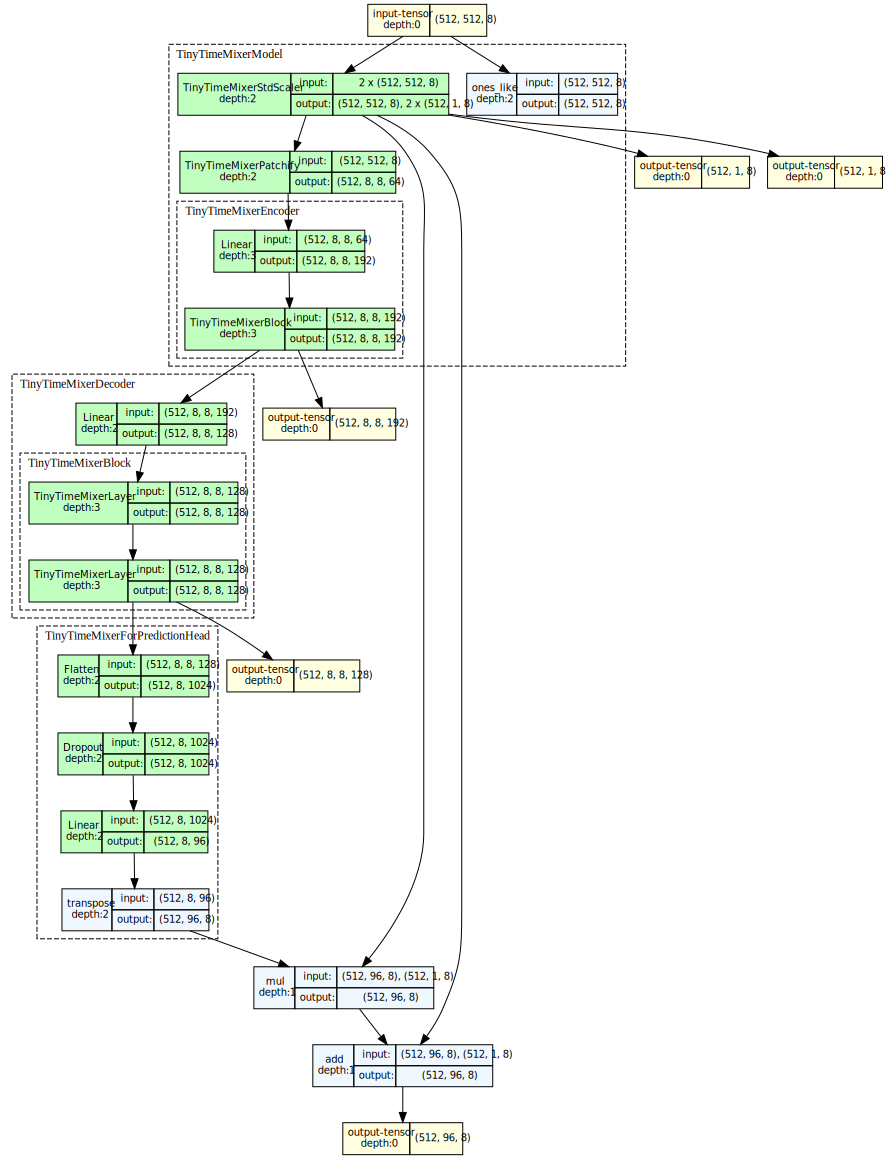

In [18]:
from torchview import draw_graph
from IPython import display
# device='meta' -> no memory is consumed for visualization
#model_graph = draw_graph(model, input_size=(batch_size, 128), device='meta')
model_graph = draw_graph(zeroshot_model, input_size=torch.Size([512, 512, 8]), device='meta', expand_nested=True, save_graph=True, roll=True) # hide_inner_tensors=False)
#model_graph.visual_graph
kwargs = {'dpi': 65}
#model_graph.visual_graph.format = 'svg'
model_graph.visual_graph

In [30]:
# Standard
import os
import random

# Third Party
from transformers import (
    EarlyStoppingCallback,
    PatchTSMixerConfig,
    PatchTSMixerForPrediction,
    Trainer,
    TrainingArguments,
)
import numpy as np
import pandas as pd
import torch

# First Party
from tsfm_public.toolkit.dataset import ForecastDFDataset
from tsfm_public.toolkit.time_series_preprocessor import TimeSeriesPreprocessor
from tsfm_public.toolkit.util import select_by_index

In [31]:
# Set seed for reproducibility
SEED = 42
torch.manual_seed(SEED)
random.seed(SEED)
np.random.seed(SEED)

In [32]:
dataset = "ETTh1"
num_workers = 8  # Reduce this if you have low number of CPU cores
batch_size = 32  # Reduce if not enough GPU memory available
context_length = 512
forecast_horizon = 96
patch_length = 8

In [33]:
print(f"Loading target dataset: {dataset}")
dataset_path = f"https://raw.githubusercontent.com/zhouhaoyi/ETDataset/main/ETT-small/{dataset}.csv"
timestamp_column = "date"
id_columns = []
forecast_columns = ["HUFL", "HULL", "MUFL", "MULL", "LUFL", "LULL", "OT"]
train_start_index = None  # None indicates beginning of dataset
train_end_index = 12 * 30 * 24

# we shift the start of the validation/test period back by context length so that
# the first validation/test timestamp is immediately following the training data
valid_start_index = 12 * 30 * 24 - context_length
valid_end_index = 12 * 30 * 24 + 4 * 30 * 24

test_start_index = 12 * 30 * 24 + 4 * 30 * 24 - context_length
test_end_index = 12 * 30 * 24 + 8 * 30 * 24

Loading target dataset: ETTh1


In [34]:
data = pd.read_csv(
    dataset_path,
    parse_dates=[timestamp_column],
)

train_data = select_by_index(
    data,
    id_columns=id_columns,
    start_index=train_start_index,
    end_index=train_end_index,
)
valid_data = select_by_index(
    data,
    id_columns=id_columns,
    start_index=valid_start_index,
    end_index=valid_end_index,
)
test_data = select_by_index(
    data,
    id_columns=id_columns,
    start_index=test_start_index,
    end_index=test_end_index,
)

tsp = TimeSeriesPreprocessor(
    timestamp_column=timestamp_column,
    id_columns=id_columns,
    target_columns=forecast_columns,
    scaling=True,
)
tsp.train(train_data)

TimeSeriesPreprocessor {
  "categorical_encoder": null,
  "conditional_columns": [],
  "context_length": 64,
  "control_columns": [],
  "encode_categorical": true,
  "feature_extractor_type": "TimeSeriesPreprocessor",
  "freq": "0 days 01:00:00",
  "frequency_mapping": {
    "10_minutes": 3,
    "15_minutes": 4,
    "half_hourly": 1,
    "hourly": 2,
    "oov": 0
  },
  "id_columns": [],
  "observable_columns": [],
  "prediction_length": null,
  "processor_class": "TimeSeriesPreprocessor",
  "scaler_dict": {},
  "scaler_type": "standard",
  "scaling": true,
  "scaling_id_columns": [],
  "static_categorical_columns": [],
  "target_columns": [
    "HUFL",
    "HULL",
    "MUFL",
    "MULL",
    "LUFL",
    "LULL",
    "OT"
  ],
  "target_scaler_dict": {
    "0": {
      "copy": true,
      "feature_names_in_": [
        "HUFL",
        "HULL",
        "MUFL",
        "MULL",
        "LUFL",
        "LULL",
        "OT"
      ],
      "mean_": [
        7.937742245659508,
        2.021038

In [35]:
train_dataset = ForecastDFDataset(
    tsp.preprocess(train_data),
    id_columns=id_columns,
    target_columns=forecast_columns,
    context_length=context_length,
    prediction_length=forecast_horizon,
)
valid_dataset = ForecastDFDataset(
    tsp.preprocess(valid_data),
    id_columns=id_columns,
    target_columns=forecast_columns,
    context_length=context_length,
    prediction_length=forecast_horizon,
)
test_dataset = ForecastDFDataset(
    tsp.preprocess(test_data),
    id_columns=id_columns,
    target_columns=forecast_columns,
    context_length=context_length,
    prediction_length=forecast_horizon,
)


In [36]:
print("Loading pretrained model")
inference_forecast_model = PatchTSMixerForPrediction.from_pretrained(
    "ibm/patchtsmixer-etth1-forecasting"
)
print("Done")

Loading pretrained model


config.json:   0%|          | 0.00/1.18k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/789k [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/74.0 [00:00<?, ?B/s]

Done


In [37]:
inference_forecast_trainer = Trainer(
    model=inference_forecast_model,
)

print("\n\nDoing testing on Etth1/test data")
result = inference_forecast_trainer.evaluate(test_dataset)
print(result)



Doing testing on Etth1/test data


{'eval_loss': 0.36988821625709534, 'eval_runtime': 4.2033, 'eval_samples_per_second': 662.567, 'eval_steps_per_second': 83.029}


In [38]:
inference_forecast_model

PatchTSMixerForPrediction(
  (model): PatchTSMixerModel(
    (encoder): PatchTSMixerEncoder(
      (patcher): Linear(in_features=16, out_features=48, bias=True)
      (mlp_mixer_encoder): PatchTSMixerBlock(
        (mixers): ModuleList(
          (0-1): 2 x PatchTSMixerLayer(
            (patch_mixer): PatchMixerBlock(
              (norm): PatchTSMixerNormLayer(
                (norm): LayerNorm((48,), eps=1e-05, elementwise_affine=True)
              )
              (mlp): PatchTSMixerMLP(
                (fc1): Linear(in_features=32, out_features=96, bias=True)
                (dropout1): Dropout(p=0.5, inplace=False)
                (fc2): Linear(in_features=96, out_features=32, bias=True)
                (dropout2): Dropout(p=0.5, inplace=False)
              )
              (gating_block): PatchTSMixerGatedAttention(
                (attn_layer): Linear(in_features=32, out_features=32, bias=True)
                (attn_softmax): Softmax(dim=-1)
              )
            )
      

In [40]:
config = PatchTSMixerConfig(
    context_length=context_length,
    prediction_length=forecast_horizon,
    patch_length=patch_length,
    num_input_channels=len(forecast_columns),
    patch_stride=patch_length,
    d_model=48,
    num_layers=3,
    expansion_factor=3,
    dropout=0.5,
    head_dropout=0.7,
    mode="common_channel",  # change it `mix_channel` if we need to explicitly model channel correlations
    scaling="std",
)
model = PatchTSMixerForPrediction(config=config)

In [41]:
train_args = TrainingArguments(
    output_dir="./checkpoint/patchtsmixer/direct/train/output/",
    overwrite_output_dir=True,
    learning_rate=0.0001,
    num_train_epochs=100,
    do_eval=True,
    evaluation_strategy="epoch",
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    dataloader_num_workers=num_workers,
    report_to="tensorboard",
    save_strategy="epoch",
    logging_strategy="epoch",
    save_total_limit=3,
    logging_dir="./checkpoint/patchtsmixer/direct/train/logs/",  # Make sure to specify a logging directory
    load_best_model_at_end=True,  # Load the best model when training ends
    metric_for_best_model="eval_loss",  # Metric to monitor for early stopping
    greater_is_better=False,  # For loss
    label_names=["future_values"],
)

# Create a new early stopping callback with faster convergence properties
early_stopping_callback = EarlyStoppingCallback(
    early_stopping_patience=5,  # Number of epochs with no improvement after which to stop
    early_stopping_threshold=0.001,  # Minimum improvement required to consider as improvement
)

trainer = Trainer(
    model=model,
    args=train_args,
    train_dataset=train_dataset,
    eval_dataset=valid_dataset,
    callbacks=[early_stopping_callback],
)

print("\n\nDoing forecasting training on Etth1/train")
trainer.train()

/home/markus/.local/lib/python3.12/site-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(




Doing forecasting training on Etth1/train


Epoch,Training Loss,Validation Loss
1,0.494300,0.721781
2,0.406100,0.693669
3,0.380400,0.692096
4,0.368400,0.691917
5,0.360100,0.690306
6,0.356300,0.687224
7,0.350500,0.695034
8,0.347300,0.684872
9,0.347000,0.693939
10,0.342900,0.691605


TrainOutput(global_step=3276, training_loss=0.3673289954589546, metrics={'train_runtime': 958.7165, 'train_samples_per_second': 837.891, 'train_steps_per_second': 26.285, 'total_flos': 970332586868736.0, 'train_loss': 0.3673289954589546, 'epoch': 13.0})

In [26]:
from torchview import draw_graph
from IPython import display
#tensor_x = torch.rand((512, 512, 64), dtype=torch.float32, device='cpu')
#torch.onnx.export(model, tensor_x, "patchtsmixer.onnx", verbose=True)


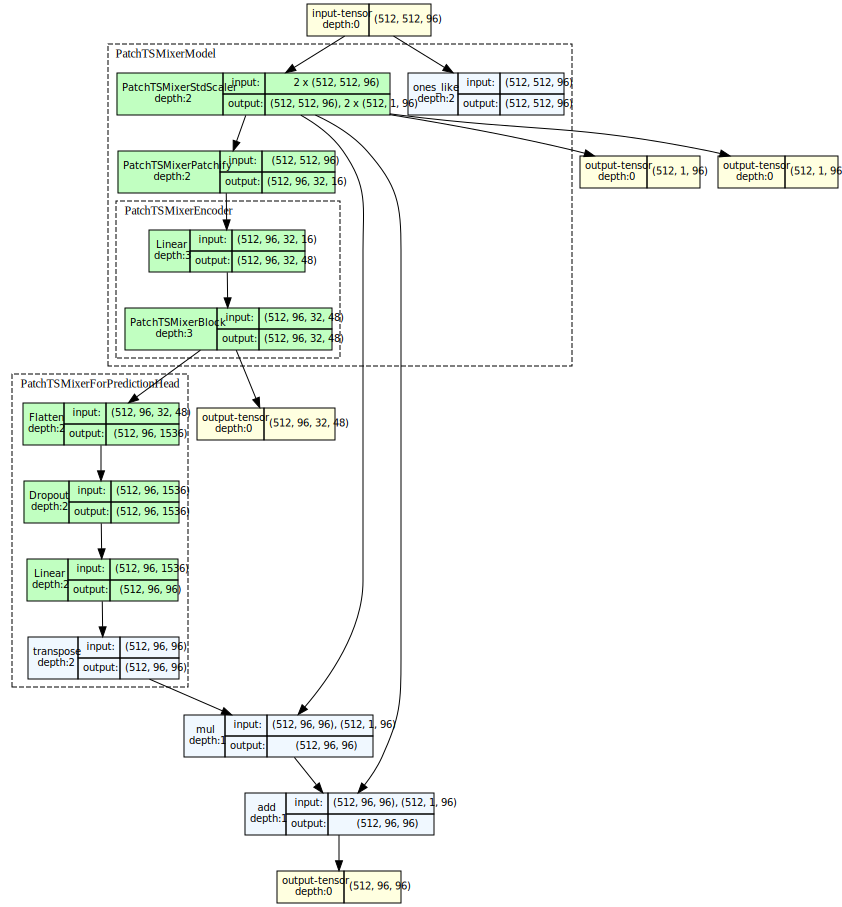

In [67]:
model_graph2 = draw_graph(inference_forecast_model, input_size=torch.Size([512, 512, 96]), device='meta',
                          expand_nested=True, save_graph=True, roll=True, filename='/home/markus/ttttest') #, hide_inner_tensors=False)
model_graph2.visual_graph